<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [161]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [162]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-05-06 04:26:47--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-05-06 04:26:47 (14.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [163]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [164]:
df.shape

(346, 10)

### Convert to date time object 

In [165]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [166]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [167]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

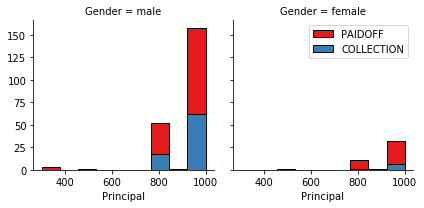

In [168]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

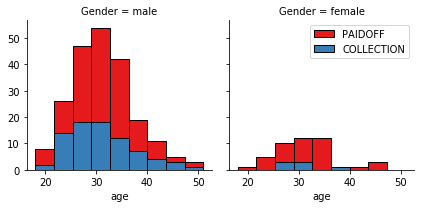

In [169]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

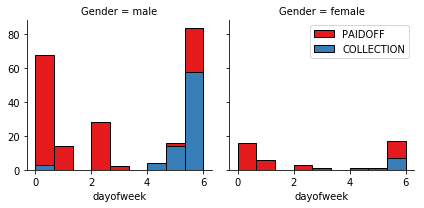

In [170]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [171]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [172]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)


Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [173]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()
df.shape

(346, 12)

## One Hot Encoding  
#### How about education?

In [174]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [175]:
df[['Principal','terms','age','Gender','education']].head()
#df.describe(include=['object'])
df['education'].value_counts()  #only 2 rows for "Master of Above", so drop it

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [176]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)  #
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [177]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [178]:
#y = df['loan_status'].values
#y[0:5]
#code df['loan_status'] to 0 and 1. 0: PAIDOFF, 1: COLLECTION, for model fit
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1])
y = y.values #convert y from Series to array
y[0:5]

array([0, 0, 0, 0, 0])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [179]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

k =  1 :
Jaccard score:  0.6642857142857143
F1 score:  0.6616826175256785
k =  2 :
Jaccard score:  0.72
F1 score:  0.6797871327257449
k =  3 :
Jaccard score:  0.6942857142857144
F1 score:  0.6893023592015691
k =  4 :
Jaccard score:  0.73
F1 score:  0.6849272769348327
k =  5 :
Jaccard score:  0.7214285714285714
F1 score:  0.7065944886078562
k =  6 :
Jaccard score:  0.7442857142857143
F1 score:  0.6987864303048761
k =  7 :
Jaccard score:  0.7328571428571429
F1 score:  0.7123523241818466
k =  8 :
Jaccard score:  0.7385714285714285
F1 score:  0.6907756048188025
k =  9 :
Jaccard score:  0.7100000000000001
F1 score:  0.6852632203156782
k =  10 :
Jaccard score:  0.7328571428571429
F1 score:  0.680431927573484
k =  11 :
Jaccard score:  0.7100000000000001
F1 score:  0.6786358504522697
k =  12 :
Jaccard score:  0.722857142857143
F1 score:  0.6705951998744349
k =  13 :
Jaccard score:  0.7114285714285715
F1 score:  0.6724538946482534
k =  14 :
Jaccard score:  0.72
F1 score:  0.6669648532536882
k =

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


k =  19 :
Jaccard score:  0.7228571428571429
F1 score:  0.6794810596186338


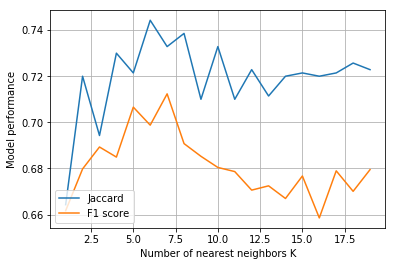

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, jaccard_similarity_score

jacc_list = []
f1_list = []
seedRange = 10
kLow = 1
kHigh = 20
for k in range(kLow, kHigh):
    tempJacc=0.0
    tempF1=0.0
    for seed in range(0,seedRange):
        knn = KNeighborsClassifier(n_neighbors=k)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        knn.fit(X_train, y_train)
        yhat = knn.predict(X_test)
        jacc_simil_score = jaccard_similarity_score(y_test, yhat)
        f1 = f1_score(y_test, yhat, average='weighted')
        
        tempJacc = tempJacc + jacc_simil_score
        tempF1 = tempF1 + f1
    
    jacc_simil_score = tempJacc/seedRange
    f1 = tempF1/seedRange
    print('k = ', k, ':')
    print('Jaccard score: ', jacc_simil_score)
    print('F1 score: ', f1)
    jacc_list.append(jacc_simil_score)
    f1_list.append(f1)
        
K=np.arange(kLow, kHigh)
plt.plot(K, jacc_list, label='Jaccard')    
plt.plot(K, f1_list, label='F1 score')
plt.xlabel('Number of nearest neighbors K')
plt.ylabel('Model performance')
plt.legend(loc='lower left')
plt.grid()

#### Overall for both Jaccard and F1 score, k=6 is the best. Will use k=6 for test set below

# Decision Tree

In [181]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_similarity_score

tempJacc=0.0
tempF1=0.0
seedRange = 1
for seed in range(0,seedRange):
    tree = DecisionTreeClassifier()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    tree.fit(X_train, y_train)
    yhat = tree.predict(X_test)
    jacc_simil_score = jaccard_similarity_score(y_test, yhat)
    f1 = f1_score (y_test, yhat, average='weighted')

    tempJacc = tempJacc + jacc_simil_score
    tempF1 = tempF1 + f1
jacc_simil_score = tempJacc/seedRange
f1 = tempF1/seedRange
         
print('Jaccard_similarity_index: ', jacc_simil_score)
print('F1 score: ', f1)

Jaccard_similarity_index:  0.7285714285714285
F1 score:  0.740047759516786


# Support Vector Machine

In [191]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_similarity_score

seedRange = 20
kernel_list = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernel_list:
    tempJacc=0.0
    tempF1=0.0
    for seed in range(0,seedRange):
           
        clf = svm.SVC(kernel=kernel, gamma='scale')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
        clf.fit(X_train, y_train)
        yhat = clf.predict(X_test)
        jacc_simil_score = jaccard_similarity_score(y_test, yhat)
        f1 = f1_score (y_test, yhat, average='weighted')
        
        tempJacc = tempJacc + jacc_simil_score
        tempF1 = tempF1 + f1

    jacc_simil_score = tempJacc/seedRange
    f1 = tempF1/seedRange
    print("Kernel = " + kernel + ":")
    jaccStr = "Jaccard_similarity_index: {1: .3f}"
    print(jaccStr.format(kernel,jacc_simil_score ))
    f1Str = "F1 score: {1: .3f}"
    print(f1Str.format(kernel,f1))
    


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Pyth

Kernel = linear:
Jaccard_similarity_index:  0.761
F1 score:  0.661
Kernel = rbf:
Jaccard_similarity_index:  0.744
F1 score:  0.665
Kernel = poly:
Jaccard_similarity_index:  0.749
F1 score:  0.668
Kernel = sigmoid:
Jaccard_similarity_index:  0.737
F1 score:  0.675


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Difference between 4 kernel types is small. Will use linear kernel for test set.

# Logistic Regression

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_similarity_score
from sklearn.metrics import log_loss
 
seedRange = 1
tempJacc = 0.0
tempF1 = 0.0
tempLogLoss = 0.0
for seed in range(0,seedRange):
        
    LR = LogisticRegression(solver='lbfgs')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    LR.fit(X_train, y_train)
    yhat = LR.predict(X_test)
    jacc_simil_score = jaccard_similarity_score(y_test, yhat)
    f1 = f1_score (y_test, yhat, average='weighted')
    logLoss = log_loss(y_test, yhat)

    tempJacc = tempJacc + jacc_simil_score
    tempF1 = tempF1 + f1
    tempLogLoss = tempLogLoss + logLoss
jacc_simil_score = tempJacc / seedRange
f1 = tempF1 / seedRange
logLoss = tempLogLoss / seedRange


print("Jaccard_similarity_index: ", jacc_simil_score)
print("F1 score: ", f1)  
print("Log loss: ", logLoss)  

Jaccard_similarity_index:  0.8571428571428571
F1 score:  0.8117913832199546
Log loss:  4.93411091355867


# Model Evaluation using Test set

In [184]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:

In [185]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-05-06 04:26:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-05-06 04:26:50 (359 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [186]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [192]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek   #series.dt.dayofweek: Mon:0, Sun:6
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)

Feature_TEST = test_df[['Principal','terms','age','Gender','weekend']]
Feature_TEST = pd.concat([Feature_TEST, pd.get_dummies(test_df['education'])], axis=1)
Feature_TEST.drop(['Master or Above'], axis = 1,inplace=True)  #drop Master or Above because training set only had 2 rows 
                                                               #for Master or above and it was dropped in the model
X_TEST = Feature_TEST
#print(X_TEST.head())
X_TEST = preprocessing.StandardScaler().fit(X_TEST).transform(X_TEST)
y_TEST = test_df['loan_status'].replace(to_replace=['PAIDOFF', 'COLLECTION'], value=[0,1])
y_TEST = y_TEST.values #convert y from Series to array



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:15: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [213]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Jaccard_LIST = []
F1_LIST = []
LogLoss_LIST = []

#KNN, k=5
k=5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
yhat_TEST = knn.predict(X_TEST)

jacc_simil_score = jaccard_similarity_score(y_TEST, yhat_TEST)
f1 = f1_score(y_TEST, yhat_TEST, average='weighted')

Jaccard_LIST.append(jacc_simil_score)
F1_LIST.append(f1)
LogLoss_LIST.append(np.NaN)
#print('KNN (k=' + str(k) + '):')
#print('Jaccard score: %.3f' %jacc_simil_score)
#print('F1 score: %.3f' %f1, '\n')

#Decision tree
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
yhat_TEST = tree.predict(X_TEST)
jacc_simil_score = jaccard_similarity_score(y_TEST, yhat_TEST)
f1 = f1_score(y_TEST, yhat_TEST, average='weighted')

Jaccard_LIST.append(jacc_simil_score)
F1_LIST.append(f1)
LogLoss_LIST.append(np.NaN)
#print('Decision tree:')
#print('Jaccard score: %.3f' %jacc_simil_score)
#print('F1 score: %.3f' %f1, '\n')

#Support Vector Machine, kernel='linear'
kernel = 'linear'
clf = svm.SVC(kernel=kernel, gamma='scale')
clf.fit(X_train, y_train)
yhat_TEST = clf.predict(X_TEST)
jacc_simil_score = jaccard_similarity_score(y_TEST, yhat_TEST)
f1 = f1_score(y_TEST, yhat_TEST, average='weighted')
Jaccard_LIST.append(jacc_simil_score)
F1_LIST.append(f1)
LogLoss_LIST.append(np.NaN)
#print('SVM (kernel=' + kernel+'):')
#print('Jaccard score: %.3f' %jacc_simil_score)
#print('F1 score: %.3f' %f1, '\n')

#Logistic Regression
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)
yhat_TEST = LR.predict(X_TEST)
jacc_simil_score = jaccard_similarity_score(y_TEST, yhat_TEST)
f1 = f1_score(y_TEST, yhat_TEST, average='weighted')
logLoss = log_loss(y_TEST, yhat_TEST)
Jaccard_LIST.append(jacc_simil_score)
F1_LIST.append(f1)
LogLoss_LIST.append(logLoss)

#print('Logistic Regression: ')
#print('Jaccard score: %.3f' %jacc_simil_score)
#print('F1 score: %.3f' %f1)
#print('Log loss: %.3f' %logLoss)

Result = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'], 
         'Jaccard': Jaccard_LIST,
         'F1-score': F1_LIST,
         'LogLoss': LogLoss_LIST}
Result = pd.DataFrame(Result)
Result.fillna(value='NA', inplace=True)
pd.options.display.float_format = '{:.3f}'.format
print(Result.to_string(index=False))

          Algorithm  Jaccard  F1-score LogLoss
                KNN    0.630     0.608      NA
      Decision Tree    0.667     0.679      NA
                SVM    0.741     0.630      NA
 LogisticRegression    0.741     0.630   8.954


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>